In [1]:
import mxnet as mx

from mxnet.symbol import Convolution, Activation, Pooling, Dropout, FullyConnected, var, flatten, SoftmaxOutput

import logging
logging.getLogger().setLevel(logging.DEBUG)  # logging to stdout

/home/yannick/bin/anaconda3/envs/py36/lib/python3.6/site-packages/urllib3/contrib/pyopenssl.py:46: DeprecationWarning: OpenSSL.rand is deprecated - you should use os.urandom instead
  import OpenSSL.SSL


In [2]:
mnist = mx.test_utils.get_mnist()

INFO:root:train-labels-idx1-ubyte.gz exists, skipping download
INFO:root:train-images-idx3-ubyte.gz exists, skipping download
INFO:root:t10k-labels-idx1-ubyte.gz exists, skipping download
INFO:root:t10k-images-idx3-ubyte.gz exists, skipping download


In [3]:
batch_size = 64

train_iter = mx.io.NDArrayIter(mnist['train_data'], mnist["train_label"], batch_size, shuffle=True)
val_iter = mx.io.NDArrayIter(mnist['test_data'], mnist["test_label"], batch_size, shuffle=True)

In [4]:
def conv_layer(x, num_filter):
    
    x = Convolution(data=x, kernel=(5,5), num_filter=num_filter)
    x = Activation(data=x, act_type="tanh")
    x = Pooling(data=x, pool_type="max", kernel=(2,2), stride=(2,2))

    return x


def full_layers(x, architecture, act_type="tanh", p=None):
    
    for num_cell in architecture:
        x = FullyConnected(x, num_hidden=num_cell)
        if p is not None:
            x = Dropout(x, p=p)
        x = Activation(x, act_type=act_type)

    return x


def generate_lenet(dropout=None, act_type="tanh", full_geom=[500]):
    
    data = var("data")
    
    x = conv_layer(data, 20)
    x = conv_layer(x, 50)
    x = flatten(x)
    x = full_layers(x, full_geom, act_type=act_type, p=dropout)
    x = FullyConnected(data=x, num_hidden=10)
    x = SoftmaxOutput(data=x, name="softmax")
    
    return x, data

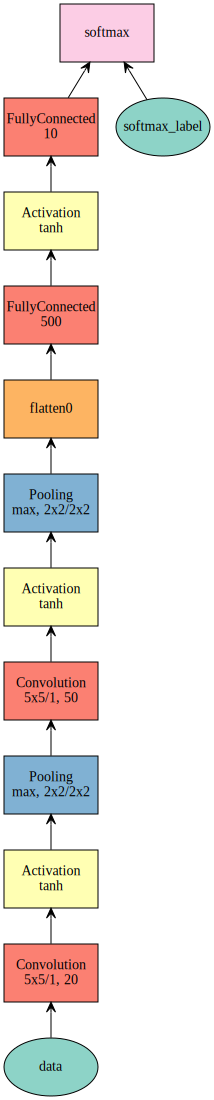

In [5]:
lenet, data = generate_lenet()

mx.viz.plot_network(lenet)

## Lenet with sgd

In [6]:
%%time

# create a trainable module on GPU 0
lenet_model = mx.mod.Module(symbol=lenet, context=mx.gpu())
# train with the same
lenet_model.fit(train_iter,
                eval_data=val_iter,
                optimizer='sgd',
                optimizer_params={'learning_rate':0.01, 'momentum':0.97},
                eval_metric='acc',
                batch_end_callback = mx.callback.Speedometer(batch_size, 1000),
                num_epoch=25)

INFO:root:Epoch[0] Train-accuracy=0.605710
INFO:root:Epoch[0] Time cost=2.651
INFO:root:Epoch[0] Validation-accuracy=0.974025
INFO:root:Epoch[1] Train-accuracy=0.976729
INFO:root:Epoch[1] Time cost=2.509
INFO:root:Epoch[1] Validation-accuracy=0.985370
INFO:root:Epoch[2] Train-accuracy=0.985141
INFO:root:Epoch[2] Time cost=2.409
INFO:root:Epoch[2] Validation-accuracy=0.987361
INFO:root:Epoch[3] Train-accuracy=0.990289
INFO:root:Epoch[3] Time cost=2.753
INFO:root:Epoch[3] Validation-accuracy=0.990247
INFO:root:Epoch[4] Train-accuracy=0.993920
INFO:root:Epoch[4] Time cost=2.437
INFO:root:Epoch[4] Validation-accuracy=0.990247
INFO:root:Epoch[5] Train-accuracy=0.995619
INFO:root:Epoch[5] Time cost=2.432
INFO:root:Epoch[5] Validation-accuracy=0.988654
INFO:root:Epoch[6] Train-accuracy=0.997368
INFO:root:Epoch[6] Time cost=2.421
INFO:root:Epoch[6] Validation-accuracy=0.990147
INFO:root:Epoch[7] Train-accuracy=0.997934
INFO:root:Epoch[7] Time cost=2.473
INFO:root:Epoch[7] Validation-accuracy=0

CPU times: user 1min 33s, sys: 10.1 s, total: 1min 43s
Wall time: 1min 8s


## Lenet with adagrad

In [7]:
%%time

# create a trainable module on GPU 0
lenet_model = mx.mod.Module(symbol=lenet, context=mx.gpu())
# train with the same
lenet_model.fit(train_iter,
                eval_data=val_iter,
                optimizer='adagrad',
                eval_metric='acc',
                batch_end_callback = mx.callback.Speedometer(batch_size, 1000),
                num_epoch=25)

INFO:root:Epoch[0] Train-accuracy=0.939865
INFO:root:Epoch[0] Time cost=3.154
INFO:root:Epoch[0] Validation-accuracy=0.978503
INFO:root:Epoch[1] Train-accuracy=0.982026
INFO:root:Epoch[1] Time cost=3.135
INFO:root:Epoch[1] Validation-accuracy=0.984972
INFO:root:Epoch[2] Train-accuracy=0.987240
INFO:root:Epoch[2] Time cost=3.303
INFO:root:Epoch[2] Validation-accuracy=0.987659
INFO:root:Epoch[3] Train-accuracy=0.990022
INFO:root:Epoch[3] Time cost=3.265
INFO:root:Epoch[3] Validation-accuracy=0.989053
INFO:root:Epoch[4] Train-accuracy=0.992354
INFO:root:Epoch[4] Time cost=3.074
INFO:root:Epoch[4] Validation-accuracy=0.989550
INFO:root:Epoch[5] Train-accuracy=0.993820
INFO:root:Epoch[5] Time cost=3.390
INFO:root:Epoch[5] Validation-accuracy=0.990247
INFO:root:Epoch[6] Train-accuracy=0.994886
INFO:root:Epoch[6] Time cost=3.480
INFO:root:Epoch[6] Validation-accuracy=0.990147
INFO:root:Epoch[7] Train-accuracy=0.995736
INFO:root:Epoch[7] Time cost=3.908
INFO:root:Epoch[7] Validation-accuracy=0

CPU times: user 3min 23s, sys: 15.3 s, total: 3min 39s
Wall time: 1min 25s
